# Анализ лояльности пользователей Яндекс Афиши

## Цель и промежуточные итоги проекта
Команда маркетинга хочет лучше понимать поведение пользователей. Для этого
они просят провести исследовательский анализ данных, чтобы понять, какие  пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.
Это позволит:
- Быстро выявлять перспективных клиентов и предлагать им персонализированные
условия.
- Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
- Оптимизировать маркетинговые бюджеты.
- Повысить общий уровень удержания клиентов.

## Исследования данных.
1. Выгрузка данных из базы SQL, загрузка данных в датасет и их проверка. <br>
2. Предобработка данных. <br>
3. Создание профиля пользователя. <br>
4. Исследовательский анализ данных. <br>
5. Общие выводы и рекомендации.

## 1. Выгрузка данных из базы SQL, загрузка данных в датасет и их проверка.

Выгрузка из базы данных SQL позволит собрать следующие данные:<br><br>
`user_id` — уникальный идентификатор пользователя, совершившего заказ;<br>
`device_type_canonical` — тип устройства, с которого был оформлен заказ:<br>
&emsp;&emsp;&emsp;mobile — мобильные устройства,<br>
&emsp;&emsp;&emsp;desktop — стационарные);<br>
`order_id` — уникальный идентификатор заказа;<br>
`created_dt_msk` — дата создания заказа (используйте данные created_dt_msk );<br>
`created_ts_msk` — дата и время создания заказа (используйте данные created_ts_msk );<br>
`currency_code` — валюта оплаты;<br>
`revenue` — выручка от заказа;<br>
`tickets_count` — количество купленных билетов;<br>
`days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;<br>
`event_id` — уникальный идентификатор мероприятия;<br>
`service_name` — название билетного оператора;<br>
`event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);<br>
`region_name` — название региона, в котором прошло мероприятие;<br>
`city_name` — название города, в котором прошло мероприятие.

In [1]:
#  Установка SQLAlchemy в Jupyter Notebook
!pip install sqlalchemy

In [2]:
# Установка модуля psycopg2
#!pip install psycopg2
# или:
#!pip install psycopg2-binary
!pip install phik

In [3]:
# Для работы с датафреймами понадобится pandas и функция create_engine()  из
# библиотеки SQLAlchemy для подключения к базе данных
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import numpy as np
from phik.report import plot_correlation_matrix
from phik import resources, phik_matrix

In [4]:
# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка данных и их проверка

In [5]:
# Подключение к базе данных через объект db_config
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [6]:
# Передача функции create_engine() строки connection_string для соединения с базой данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [7]:
engine = create_engine(connection_string)

In [8]:
# Запрос к базе данных SQL запишем в переменную query
query = '''
SELECT p.user_id, -- идентификатор пользователя;
       p.device_type_canonical, -- тип устройства, с которого оформлен заказ;
       p.order_id, -- номер заказа;
       p.created_dt_msk, -- дата заказа. Переименуйте поле в order_dt ради лаконичности и ясности;
       p.created_ts_msk, -- дата и время заказа. Переименуйте поле в order_ts ради лаконичности и ясности;
       p.currency_code, -- валюта оплаты;
       p.revenue, -- выручка от заказа;
       p.tickets_count, -- количество купленных билетов;
       EXTRACT(DAY FROM (p.created_dt_msk - LAG(p.created_dt_msk) OVER (
               PARTITION BY p.user_id ORDER BY p.created_dt_msk))) AS days_since_prev,
       e.event_id, -- идентификатор мероприятия.
       e.event_name_code AS event_name,
       e.event_type_main, -- основной тип мероприятия (театральная постановка, концерт и так далее);
       p.service_name, -- название билетного оператора;
       r.region_name, -- название региона, в котором прошло мероприятие;
       c.city_name -- название города, в котором прошло мероприятие.
FROM afisha.purchases AS p
JOIN afisha.events AS e ON p.event_id = e.event_id
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS r ON c.region_id = r.region_id
WHERE p.device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY p.user_id;
'''

In [9]:
# Результат выдачи SQL-запроса запишем в датафрейм с помощью метода pd.read_sql_query()
# Первым аргументом передают запрос, а с помощью параметра con передают соединение для
# подключения к базе данных.
df = pd.read_sql_query(query, con=engine)

#### Изучим общую информацию о выгруженных данных, оценим корректность выгрузки и объём полученных данных.

In [10]:
# Выведем первые 10 строк датасета df
df.head(10)

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье


In [11]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [12]:
# Применяем метод isna() к датасету df
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
created_dt_msk               0
created_ts_msk               0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

In [13]:
# Подсчитываем долю строк с пропусками в столбце days_since_prev
df.isna().sum() / df.shape[0]
# или df.isna().mean()

user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
created_dt_msk           0.000000
created_ts_msk           0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          0.075472
event_id                 0.000000
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_name              0.000000
city_name                0.000000
dtype: float64

Датасет `df` содержит 15 столбцов и 290 611 строк, в которых представлена
интересующая информация для дальнейшего исследования. .<br>
После первичного анализа данных можно сделать следующие выводы:<br>
-  Названия столбцов изначально приведены к виду `snake case`.
- Типы данных, представленные в столбцах: datetime64 (2 столбца), float64 (2
 столбца), int64 (3 столбца) и object (8 столбцов).
 - Значения в столбце `tickets_count` представлены целыми числами типа
 данных `int64` и содержат информацию о количестве купленных билетов в
 заказе — размерность этих данных можно оптимизировать.
- Значения в столбце `days_since_prev` представлены вещественными числами
типа данных `float64` и содержат информацию о количестве дней, прошедших с
момента предыдущего заказа  — размерность этих значений можно оптимизировать
 и представить типом данных `int16`. При этом количество значений NaN равно
 21 933, что составляет долю в 0.075472%.
- Пропуски содержатся только в столбце `days_since_prev`. Однако следует
проверить и другие столбцы: в них могут встречаться значения-индикаторы, которые будут говорить об отсутствии данных.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

In [14]:
# Проверяем неявные дубликаты в датафрейме df
df.duplicated(subset='order_id').sum()

0

In [15]:
# Проверяем неявные дубликаты в датафрейме df
df.duplicated(subset=['user_id', 'order_id']).sum()

0

В датафрейме `df` все значения в строках `order_id` и в связке значений
`user_id` и `order_id` уникальны. Каждому объекту соответствует уникальная строка.

## 2. Предобработка данных

Подготовим данные к исследовательскому анализу: пребразуем необходимые типы данных.

In [16]:
# Оптимизируем целочисленный тип данных в столбце `tickets_count` датасета df
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

In [17]:
# Оптимизируем тип данных в столбце `days_since_prev` датасета df
# При этом при переводе из типа данных float64, в связи с отсутствием
# информации о днях, прошедших с момента предыдущего заказа вследствие того,
# что текущий заказ первый у данного пользователя, и особенностью
# при переводе в тип "int" из типа "float", заполним пропуски NaN на значение-индикатор "-1".
# Значение-индикатор "0" применять нельзя, так как это значение говорит о
# том, что предыдущий заказ был сделан в этот же день, но ранее по времени,
# и это может привести к ошибке при дальнейшем исследовании.
df['days_since_prev'] = df['days_since_prev'].fillna(-1)

In [18]:
# Оптимизируем целочисленный тип данных в столбце `days_since_prev` датасета df
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='integer')

In [19]:
# Выводим информацию о датасете и проверяем изменения в типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        290611 non-null  int16         
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [20]:
# Выведем информацию о данных
df.head(10)

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,-1,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,-1,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,-1,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19,500862,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Облачко,Лугоградская область,Кристалевск
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,-1,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,театр,Край билетов,Каменевский регион,Глиногорск
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,-1,265857,0d876e01-851e-458b-ba61-753e0e0c4063,театр,Лучшие билеты,Поленовский край,Дальнозолотск
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,театр,Лучшие билеты,Поленовский край,Дальнозолотск
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,-1,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,концерты,Лови билет!,Широковская область,Радужнополье


Проверим значения на уникальность в интересующих для исследования столбцах.

In [21]:
df['device_type_canonical'].sort_values().unique()

array(['desktop', 'mobile'], dtype=object)

In [22]:
df['created_dt_msk'].sort_values().unique()

<DatetimeArray>
['2024-06-01 00:00:00', '2024-06-02 00:00:00', '2024-06-03 00:00:00',
 '2024-06-04 00:00:00', '2024-06-05 00:00:00', '2024-06-06 00:00:00',
 '2024-06-07 00:00:00', '2024-06-08 00:00:00', '2024-06-09 00:00:00',
 '2024-06-10 00:00:00',
 ...
 '2024-10-22 00:00:00', '2024-10-23 00:00:00', '2024-10-24 00:00:00',
 '2024-10-25 00:00:00', '2024-10-26 00:00:00', '2024-10-27 00:00:00',
 '2024-10-28 00:00:00', '2024-10-29 00:00:00', '2024-10-30 00:00:00',
 '2024-10-31 00:00:00']
Length: 153, dtype: datetime64[ns]

In [23]:
df['currency_code'].sort_values().unique()

array(['kzt', 'rub'], dtype=object)

In [24]:
df['event_type_main'].sort_values().unique()

array(['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр',
       'ёлки'], dtype=object)

In [25]:
df['service_name'].sort_values().unique()

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

In [26]:
df['region_name'].sort_values().unique()

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

In [27]:
df['city_name'].sort_values().unique()

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

В итоге получаем перечень уникальных значений по следующим столбцам:
- `device_type_canonical` - 2 значения,
- `created_dt_msk` - 153 значения
- `currency_code` - 2 значения,
- `event_type_main` - 7 значений,
- `service_name` - 36 значений,
- `region_name` - 81 значение,
- `city_name` - 352 значения. <br><br>
Все значения приведены к одному регистру, пребразование не требуется.

Пропуски заменены на индикатор-заглушку, в каждом столбце полный набор
значений.

In [28]:
# Проверяем полные дубликаты в датасете df
df.duplicated().sum()

0

В датасете нет полных дубликатов строк. Неявные дубликаты объектов были
проверены выше, они являются  уникальными, то есть каждая строка в данных —
уникальный объект заказов.

Данные о выручке сервиса представлены в российских рублях и казахстанских
тенге. Приведем выручку к единой валюте — российскому рублю.
Для этого используем датасет с информацией о курсе казахстанского тенге по
отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`.

In [29]:
# Загрузим данные о курсах валют в датасет df_rub_kzt
df_rub_kzt = pd.read_csv("final_tickets_tenge_df.csv")

In [30]:
# Выведем первые пять строк на экран
df_rub_kzt.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [31]:
# И посмотрим информацию о датасете df_rub_kzt
df_rub_kzt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Значения в рублях представлено для 100 тенге. В датасете 357 строк и 4
столбца. Пропусков нет, названия представлены корректно, типы данных
соответствуют представленным значениям.
Результаты преобразования казахстанских тенге в российских рубли сохраним
 в новый столбец
`revenue_rub`.

In [32]:
# -- Для этого используем следующий код:
# Преобразуем даты в обоих датасетах к единому формату
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
df_rub_kzt['data'] = pd.to_datetime(df_rub_kzt['data'])
# Создаем словарь с курсами валют. Рассчитываем курс для 1 тенге (делим на 100)
exchange_rates = {}
for _, row in df_rub_kzt.iterrows():
    date = row['data']
    rate_per_100_kzt = row['curs']
    rate_per_1_kzt = rate_per_100_kzt / 100
    exchange_rates[date] = rate_per_1_kzt
# Функция для конвертации валюты
def convert_currency(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    elif row['currency_code'] == 'kzt':
        date = row['created_dt_msk']
        # Ищем курс для нужной даты
        if date in exchange_rates:
            exchange_rate = exchange_rates[date]
            return row['revenue'] * exchange_rate
        else:
            return None
    else:
        return None
# Добавляем новый столбец в df (формат - 2 знака после запятой)
df['revenue_rub'] = round(df.apply(convert_currency, axis=1), 2)

In [33]:
# Проверим результат действия по добавлению нового столбца.
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,-1,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,-1,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,-1,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


In [34]:
# А также результат конвертации валют:
df[df["currency_code"] == "kzt"].head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.50
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.73
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,-1,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.15
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,-1,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.70
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.30


Конвертация проведена, все значения в столбце `revenue_rub` в российской
валюте.

In [35]:
# Выведем информацию об обновленном датасете df.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        290611 non-null  int16         
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Изменениями являются появление нового столбца `revenue_rub`, тип данных -
`float64`, пропусков нет.

Проверим распределение численных данных и наличие в них выбросов. Для этого
используем статистические показатели, гистограммы распределения значений или
диаграммы размаха. Важные показатели в рамках исследования — это выручка с
заказа (столбец `revenue_rub`) и количество билетов в заказе (столбец
`tickets_count`), поэтому в первую очередь проверим данные в этих столбцах.
Если обнаружим выбросы в поле `revenue_rub`, то отфильтруем значения по 99 перцентилю.

In [36]:
# Базовая статистика
print("БАЗОВАЯ СТАТИСТИКА:")
print(df[["revenue_rub", "tickets_count"]].describe())

БАЗОВАЯ СТАТИСТИКА:
         revenue_rub  tickets_count
count  290611.000000  290611.000000
mean      555.571989       2.754311
std       875.498170       1.170620
min       -90.760000       1.000000
25%       113.970000       2.000000
50%       351.140000       3.000000
75%       802.050000       4.000000
max     81174.540000      57.000000


- Статистика по столбцу `revenue_rub` показывает, что:
   - максимальное значение составляет 81 174.54 и очень сильно отличается от
    основном массы значений;
   - присутствуют отрицательные значения, говорящие о вероятных возвратах
   билетов;
   - медиана в 1.58 раз меньше среднего значения.
- Статистика по столбцу `tickets_count` показывает, что:
   - максимальное значение составляет 57 купленных билетов и также очень
   сильно отличается от основном массы значений;
   - медиана немного больше среднего значения.

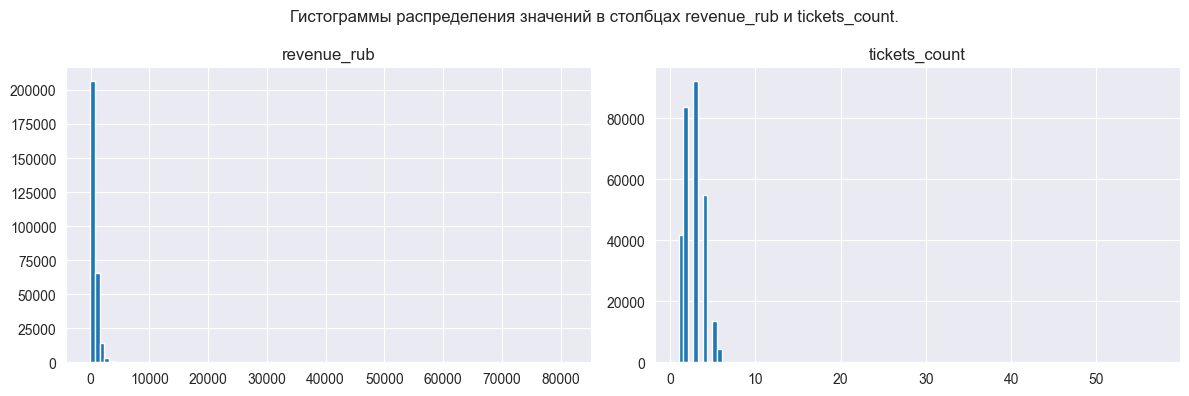

In [37]:
# Построим гистограммы для столбцов
df[["revenue_rub", "tickets_count"]].hist(bins=100, figsize=(12, 4))
plt.suptitle('Гистограммы распределения значений в столбцах revenue_rub и tickets_count.')
plt.tight_layout()
plt.show()

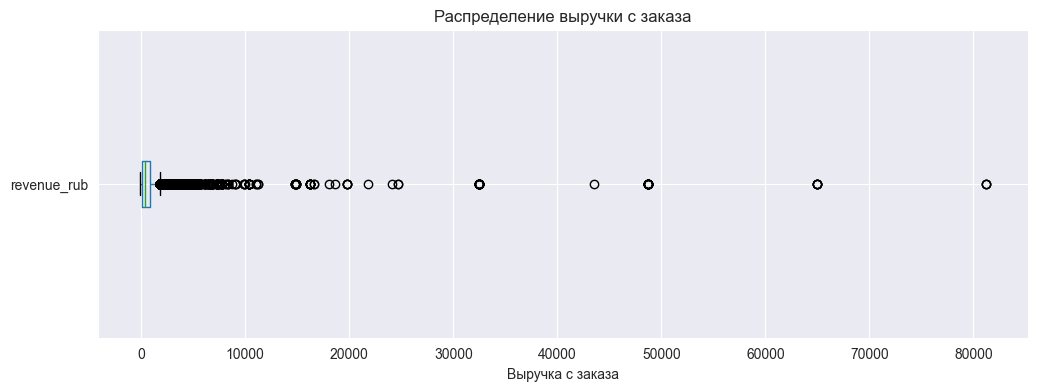

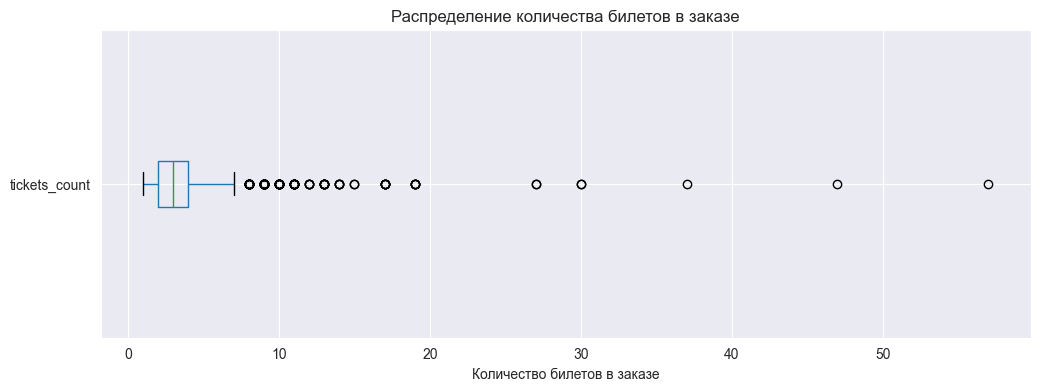

In [38]:
# Строим диаграмму размаха методом boxplot()
boxplot = df.boxplot(column="revenue_rub",
                     vert=False,
                     figsize=(12, 4))
# Добавляем заголовок и метку оси
boxplot.set_title('Распределение выручки с заказа')
boxplot.set_xlabel('Выручка с заказа')
plt.show()

boxplot = df.boxplot(column="tickets_count",
                     vert=False,
                     figsize=(12, 4))
# Добавляем заголовок и метку оси
boxplot.set_title('Распределение количества билетов в заказе')
boxplot.set_xlabel('Количество билетов в заказе')
plt.show()


In [39]:
# Фильтруем по 99 перцентилю и образуем датасет df_filtered после фильтрации
percentile_99_1 = df['revenue_rub'].quantile(0.99)
percentile_99_2 = df['tickets_count'].quantile(0.99)
df_filtered = df[(df['revenue_rub'] <= percentile_99_1) & (df['tickets_count'] <= percentile_99_2)]

In [40]:
# Выводим информацию датасета df_filtered после проведения фильтрации
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287606 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287606 non-null  object        
 1   device_type_canonical  287606 non-null  object        
 2   order_id               287606 non-null  int64         
 3   created_dt_msk         287606 non-null  datetime64[ns]
 4   created_ts_msk         287606 non-null  datetime64[ns]
 5   currency_code          287606 non-null  object        
 6   revenue                287606 non-null  float64       
 7   tickets_count          287606 non-null  int8          
 8   days_since_prev        287606 non-null  int16         
 9   event_id               287606 non-null  int64         
 10  event_name             287606 non-null  object        
 11  event_type_main        287606 non-null  object        
 12  service_name           287606 non-null  object   

Количество строк после фильтрации - 287 606. Пропусков нет.

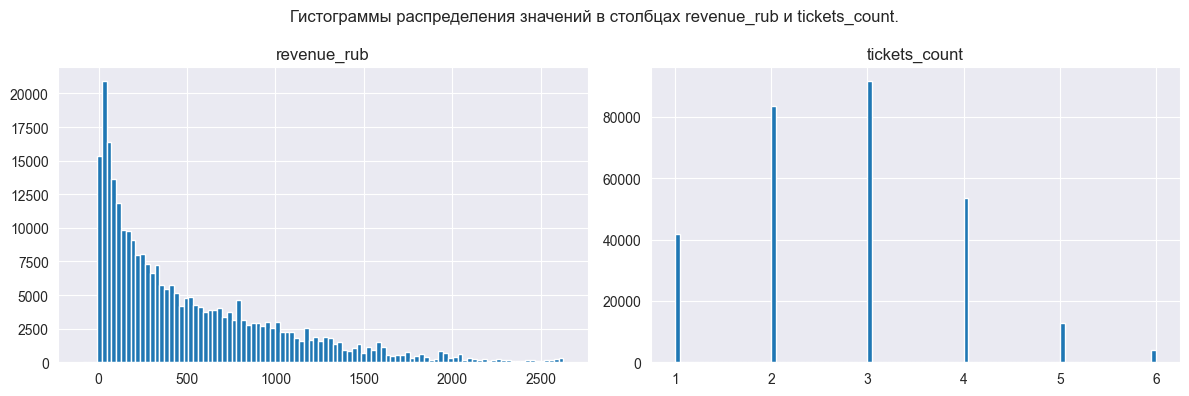

In [41]:
# Построим гистограммы для столбцов revenue_rub и tickets_count после фильтрации
df_filtered[["revenue_rub", "tickets_count"]].hist(bins=100, figsize=(12, 4))
plt.suptitle('Гистограммы распределения значений в столбцах revenue_rub и tickets_count.')
plt.tight_layout()
plt.show()

Левая гистограмма - правоасимметричного распределения (присутствуют
значения сильно выше средних), правая - симметричного распределения
(значения распределены вокруг среднего).
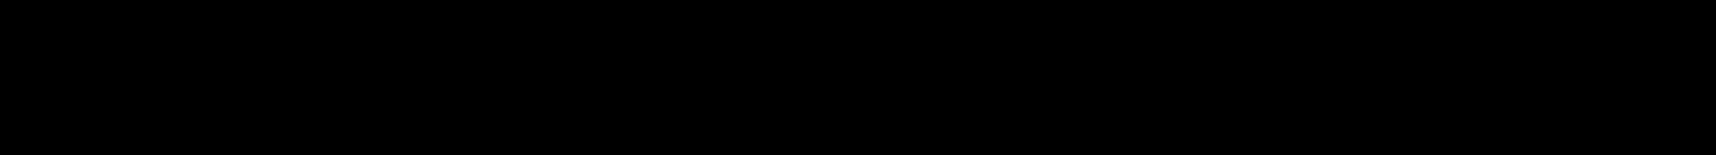

После того, когда были отфильтрованы данные количество строк уменьшилось на 3 005, что составляет 1.034% от исходного набора. Это не повлияет на результаты дальнейшего исследования.

Промежуточные выводы:
- была произведена выгрузка данных из базы данных SQL;
- подключены необходимые библиотеки для работы с данными;
- произведена загрузка данных и их проверка в Jupyter notebook;
- исходный датасет содержал 15 столбцов и 290 611 строк;
- названия столбцов изначально приведены к виду `snake case`.
- типы данных, представленные в столбцах: datetime64 (2 столбца), float64 (2 столбца), int64 (3 столбца) и object (8 столбцов);
- значения в столбцах `tickets_count` и `days_since_prev` потребовалось оптимизировать;
- пропуски содержались только в столбце `days_since_prev`;
- судя по первому знакомству с данными, значения в столбцах соответствовали своему описанию;
- в столбце `days_since_prev` вместо значений NaN установлен индикатор-заглушка -1;
- получен перечень уникальных значений по семи категориальных столбцам;
- все значения приведены к одному регистру, преобразование не потребовалось;
- пропуски заменены на индикатор-заглушку, в каждом столбце полный набор значений;
- в датасете нет полных дубликатов строк;
- выручка приведена к единой валюте — российскому рублю, для этого добавлен новый столбец;
- после фильтрации столбцов `revenue_rub` и `tickets_count`  по 99 перцентилю осталось полных 287 606 строк;
- построены гистограммы: по `revenue_rub` - правоасимметричное распределения, по `tickets_count` - симметричное распределение;
- текущий датасет для дальнейшего исследования - `df_filtered` (16 столбцов, 287 606 строк).

## 3. Создание профиля пользователя.

Построим профиль пользователя — для каждого пользователя найдем:
- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (данные из поля event_type_main );
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

In [42]:
# Отсортируем данные по времени совершения заказа ('created_ts_msk') и уберем индексы.
df_sorted = df_filtered.sort_values('created_ts_msk').reset_index(drop=True)

In [43]:
# Проверим сортировку
df_sorted.head(10)

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,fd4d47438ebb946,mobile,7565637,2024-06-01,2024-06-01 00:00:42,rub,1083.15,4,0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,1083.15
1,fd4d47438ebb946,mobile,7565521,2024-06-01,2024-06-01 00:01:30,rub,812.36,3,0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,812.36
2,57ef0a1905ac488,mobile,6670842,2024-06-01,2024-06-01 00:01:58,rub,2091.31,4,-1,375861,ba89f19f-e73c-4d74-ab35-b9c023bb4de6,театр,Билеты в руки,Лесодальний край,Родниковец,2091.31
3,fd4d47438ebb946,mobile,7565550,2024-06-01,2024-06-01 00:03:13,rub,812.36,3,-1,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,812.36
4,e73089d7d016cd8,mobile,5502055,2024-06-01,2024-06-01 00:03:34,rub,181.39,2,0,211846,20165b73-7202-48df-a5e3-fd8cd1a70554,театр,Прачечная,Широковская область,Радужнополье,181.39
5,18e9aead0a393e7,mobile,5948307,2024-06-01,2024-06-01 00:04:54,rub,1030.49,3,-1,514904,a9c3e7f5-8205-44ac-b7a7-4fc41118ebbf,концерты,Облачко,Каменевский регион,Глиногорск,1030.49
6,fd4d47438ebb946,mobile,7565666,2024-06-01,2024-06-01 00:05:03,rub,270.79,1,0,131671,f4431442-3d97-452d-a6d6-eadf6bd34378,театр,Прачечная,Каменевский регион,Глиногорск,270.79
7,0e6fa925c5f346f,mobile,6191704,2024-06-01,2024-06-01 00:05:17,rub,1199.44,4,0,516482,787d61f0-d0fa-4f32-97b4-e0079b51b6b0,концерты,Весь в билетах,Речиновская область,Дальнесветск,1199.44
8,0e6fa925c5f346f,mobile,6191675,2024-06-01,2024-06-01 00:08:58,rub,599.72,2,0,516482,787d61f0-d0fa-4f32-97b4-e0079b51b6b0,концерты,Весь в билетах,Речиновская область,Дальнесветск,599.72
9,868ed3e1cd9eb1b,mobile,6002798,2024-06-01,2024-06-01 00:09:38,rub,1994.09,5,0,522779,e1e937b0-a229-490b-b57f-4ef9630d5288,концерты,Яблоко,Белоярская область,Акбастау,1994.09


Напишем код для построения профиля пользователя на основе датасета `df_sorted`:

In [44]:
# Создаем профиль пользователя
user_profile = df_sorted.groupby('user_id').agg(
    # Дата первого и последнего заказа
    first_order_date=('created_ts_msk', 'min'),
    last_order_date=('created_ts_msk', 'max'),
    # Устройство первого заказа
    first_device=('device_type_canonical', 'first'),
    # Регион первого заказа
    first_region=('region_name', 'first'),
    # Билетный партнер первого заказа
    first_partner=('service_name', 'first'),
    # Жанр первого мероприятия
    first_event_type=('event_type_main', 'first'),
    # Общее количество заказов
    total_orders=('order_id', 'nunique'),
    # Средняя выручка с заказа
    avg_revenue_rub=('revenue_rub', 'mean'),
    # Среднее количество билетов в заказе
    avg_tickets=('tickets_count', 'mean'),
    # Среднее время между заказами (исключаем -1 и считаем только для пользователей с >=2 заказами)
    avg_days_between_orders=('days_since_prev', lambda x: x[x > 0].mean() if len(x[x > 0]) > 0 else 0)
).reset_index()

# Добавляем бинарные признаки:
# совершил ли пользователь 2 и более заказа
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
# совершил ли пользователь 5 и более заказов
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)
# Заменяем NaN в среднем времени между заказами на 0 (для пользователей с одним заказом)
user_profile['avg_days_between_orders'] = user_profile['avg_days_between_orders'].fillna(0)

Профиль пользователя создан, посмотрим результаты выведем датасет и общую информацию

In [45]:
user_profile.head(10)

,user_id,first_order_date,last_order_date,first_device,first_region,first_partner,first_event_type,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,0.0,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,0.0,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0
5,000cf0659a9f40f,2024-06-20 10:35:26,2024-06-21 04:36:17,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,1.0,1,1
6,00147c9209d45d3,2024-06-25 23:26:58,2024-06-25 23:28:52,mobile,Каменевский регион,Облачко,концерты,2,352.945000,1.500000,0.0,1,0
7,0018ecd8a38a51b,2024-07-25 20:38:57,2024-07-25 20:38:57,mobile,Медовская область,Билеты без проблем,спорт,1,0.000000,3.000000,0.0,0,0
8,00199a573901564,2024-06-17 22:58:15,2024-06-17 22:58:15,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.120000,4.000000,0.0,0,0
9,001e7037d013f0f,2024-07-04 08:06:44,2024-09-29 22:58:14,mobile,Златопольский округ,Мой билет,другое,3,326.623333,1.333333,43.5,1,0


In [46]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21847 entries, 0 to 21846
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21847 non-null  object        
 1   first_order_date         21847 non-null  datetime64[ns]
 2   last_order_date          21847 non-null  datetime64[ns]
 3   first_device             21847 non-null  object        
 4   first_region             21847 non-null  object        
 5   first_partner            21847 non-null  object        
 6   first_event_type         21847 non-null  object        
 7   total_orders             21847 non-null  int64         
 8   avg_revenue_rub          21847 non-null  float64       
 9   avg_tickets              21847 non-null  float64       
 10  avg_days_between_orders  21847 non-null  float64       
 11  is_two                   21847 non-null  int32         
 12  is_five                  21847 n

In [47]:
print(f"Размер профиля пользователей: {user_profile.shape}")

Размер профиля пользователей: (21847, 13)


In [48]:
# Общее число заказов
orders_count = user_profile['total_orders'].sum()
print(f'\nОбщее число заказов: {orders_count}.')


Общее число заказов: 287606.


In [49]:
# Средняя выручка с одного заказа
orders_avg = round(user_profile['avg_revenue_rub'].mean(), 2)
print(f'\nСредняя выручка с одного заказа: {orders_avg}.')


Средняя выручка с одного заказа: 544.16.


В итоге получаем информацию с профилем (13 столбцов) о 21 847 пользователях.
 Это достаточно большой объем, чтобы проводить статистический и
 исследовательский анализ.
 Пропусков нет. 153 пользователя были отсеяны на этапе фильтрации ранее.
 Общее число заказов: 287606, Средняя выручка с одного заказа: 544.16.
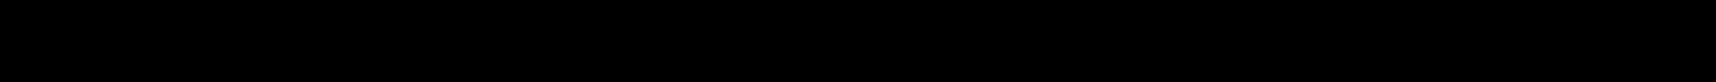
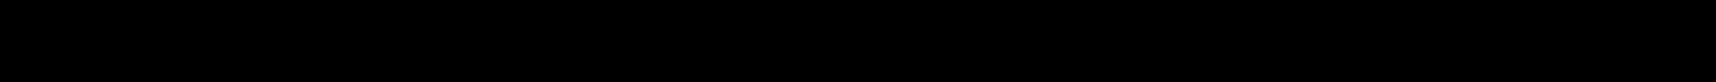

In [50]:
print("\nРаспределение по бинарным признакам:\n")
print(f"Пользователей с 2+ заказами: {user_profile['is_two'].sum()} ({user_profile['is_two'].mean()*100:.1f}%)")
print(f"Пользователей с 5+ заказами: {user_profile['is_five'].sum()} ({user_profile['is_five'].mean()*100:.1f}%)")


Распределение по бинарным признакам:

Пользователей с 2+ заказами: 13480 (61.7%)
Пользователей с 5+ заказами: 6337 (29.0%)


In [51]:
print("\nСтатистика по профилю (общее число заказов, среднее число билетов, среднее количество дней между покупками):\n")
print(user_profile[['total_orders', 'avg_tickets', 'avg_days_between_orders']].describe())


Статистика по профилю (общее число заказов, среднее число билетов, среднее количество дней между покупками):

       total_orders   avg_tickets  avg_days_between_orders
count  21847.000000  21847.000000             21847.000000
mean      13.164553      2.739164                13.992837
std      121.581813      0.902689                23.903058
min        1.000000      1.000000                 0.000000
25%        1.000000      2.000000                 0.000000
50%        2.000000      2.750000                 0.000000
75%        5.000000      3.071429                19.500000
max    10168.000000      6.000000               148.000000


In [52]:
print('По столбцу total_orders')
print(f'95-й перцентиль: , {round(user_profile['total_orders'].quantile(0.95), 0)}')
print(f'99-й перцентиль: , {round(user_profile['total_orders'].quantile(0.99),
                              0)}')

По столбцу total_orders
95-й перцентиль: , 31.0
99-й перцентиль: , 152.0


Есть крайние выбросы - отдельные пользователи сделали тысячи заказов, что
нетипично для основной массы пользователей.
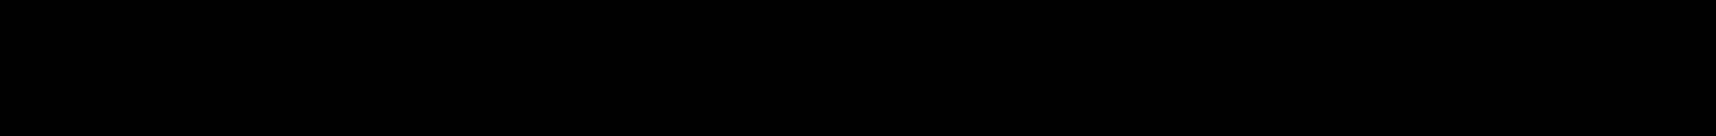

In [53]:
print('По столбцу avg_tickets')
print(f'99-й перцентиль: , {round(user_profile['avg_tickets'].quantile(0.99), 0)}')

По столбцу avg_tickets
99-й перцентиль: , 5.0


Аномалий почти нет - данные выглядят реалистично.

Решение по аномалиям:
- для `avg_tickets` - оставим без фильтрации;
- для `total_orders` - логично отфильтровать значения выше 99-го перцентиля
(~150 заказов), чтобы исключить экстремальные варианты.

In [54]:
percentile_99_3 = user_profile['total_orders'].quantile(0.99)
user_profile_flt = user_profile[user_profile['total_orders'] <= percentile_99_3]

Результаты после фильтрации по 99-му перцентилю (total_orders <= 150):

In [55]:
user_profile_flt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21628 entries, 0 to 21846
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21628 non-null  object        
 1   first_order_date         21628 non-null  datetime64[ns]
 2   last_order_date          21628 non-null  datetime64[ns]
 3   first_device             21628 non-null  object        
 4   first_region             21628 non-null  object        
 5   first_partner            21628 non-null  object        
 6   first_event_type         21628 non-null  object        
 7   total_orders             21628 non-null  int64         
 8   avg_revenue_rub          21628 non-null  float64       
 9   avg_tickets              21628 non-null  float64       
 10  avg_days_between_orders  21628 non-null  float64       
 11  is_two                   21628 non-null  int32         
 12  is_five                  21628 non-nu

Исходный объём данных - 21 847 записей;
Исходный объём после фильтрации - 21 628 записей;
Удалено аномалий - 219 (1%).

Обновленная статистика по столбцам `total_orders` и `avg_tickets`:

In [56]:
print(user_profile_flt[['total_orders', 'avg_tickets']].describe())

       total_orders   avg_tickets
count  21628.000000  21628.000000
mean       6.479980      2.739366
std       14.218483      0.907110
min        1.000000      1.000000
25%        1.000000      2.000000
50%        2.000000      2.750000
75%        5.000000      3.090909
max      151.000000      6.000000


По обновленной статистике видно, что:
- для `total_orders`: среднее - 6.48, медиана - 2, максимум - 151;
- для `avg_tickets`: среднее - 2.74, медиана - 2.75, Диапазон остался прежним
(1 - 6).

Фильтрация по 99-му перцентилю позволила убрать редкие, но очень сильные
выбросы без большой потери данных. Дальнейший анализ стоит проводить на
очищенном наборе данных из 21 628 записей.

Промежуточные выводы:
- после сортировки данные по времени совершения заказа ('created_ts_msk') был создан профиль пользователя с размерами (21847, 13);
- пропусков нет. 153 пользователя были отсеяны на этапе фильтрации ранее, общее число заказов: 287606, средняя выручка с одного заказа: 544.16;
- распределение по бинарным признакам составило:
   - пользователей с 2+ заказами: 13480 (61.7%)
   - пользователей с 5+ заказами: 6337 (29.0%);
- были обнаружены крайние выбросы - отдельные пользователи сделали тысячи заказов, что нетипично для основной массы пользователей;
- решение по аномалиям:
   - для `avg_tickets` - оставим без фильтрации;
   - для `total_orders` - отфильтровать значения выше 99-го перцентиля (~150 заказов), чтобы исключить экстремальные варианты;
- исходный объём данных составлял 21 847 записей, исходный объём после фильтрации составил 21 628 записей, удалено аномалий - 219 (1%),
- фильтрация по 99-му перцентилю позволила убрать редкие, но очень сильные выбросы без большой потери данных,
- дальнейший анализ стоит проводить на очищенном наборе данных из 21 628 записей.

## 4. Исследовательский анализ данных.

Следующий этап — исследование признаков, влияющих на возврат пользователей,
то есть на совершение повторного заказа. Для этого используем профили пользователей.

Исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют
 ли они на вероятность возвращения пользователя.

Сгруппируем пользователей:
- по типу их первого мероприятия;
- по типу устройства, с которого совершена первая покупка;
- по региону проведения мероприятия из первого заказа;
- по билетному оператору, продавшему билеты на первый заказ.

In [57]:
# === Функция для анализа распределения по признаку ===
def analyze_distribution(user_profile_flt, column_name):
    segment_counts = user_profile_flt[column_name].value_counts(dropna=False)
    segment_share = user_profile_flt[column_name].value_counts(normalize=True, dropna=False) * 100
    result = pd.DataFrame({
        'Количество пользователей': segment_counts,
        'Доля, %': segment_share.round(2)
    })
    return result

# === Анализ по каждому признаку ===
features = {
    'first_event_type': 'Тип первого мероприятия',
    'first_device': 'Тип устройства первого заказа',
    'first_region': 'Регион первого заказа',
    'first_partner': 'Билетный оператор первого заказа'
}

for col, desc in features.items():
    print(f"\n=== {desc} ===")
    if col in user_profile_flt.columns:
        result = analyze_distribution(user_profile_flt, col)
        display(result)
    else:
        print(f"Столбец '{col}' отсутствует в данных!")



=== Тип первого мероприятия ===


,Количество пользователей,"Доля, %"
first_event_type,,
концерты,9558,44.19
другое,5418,25.05
театр,4239,19.60
стендап,1110,5.13
спорт,794,3.67
выставки,414,1.91
ёлки,95,0.44



=== Тип устройства первого заказа ===


,Количество пользователей,"Доля, %"
first_device,,
mobile,17919,82.85
desktop,3709,17.15



=== Регион первого заказа ===


,Количество пользователей,"Доля, %"
first_region,,
Каменевский регион,7085,32.76
Североярская область,3759,17.38
Широковская область,1225,5.66
Озернинский край,675,3.12
Малиновоярский округ,525,2.43
...,...,...
Светолесский край,2,0.01
Тихогорская область,2,0.01
Сосноводолинская область,1,0.00



=== Билетный оператор первого заказа ===


,Количество пользователей,"Доля, %"
first_partner,,
Билеты без проблем,5177,23.94
Мой билет,2970,13.73
Лови билет!,2809,12.99
Билеты в руки,2557,11.82
Облачко,2177,10.07
Весь в билетах,1285,5.94
Лучшие билеты,1184,5.47
Прачечная,582,2.69
Край билетов,454,2.10


Выводы:<br>
Тип первого мероприятия.
- Наибольшая доля пользователей впервые пришла на платформу через мероприятия: концерты, спектакли, другое. Это указывает на наличие основных “входных” жанров, через которые пользователи чаще всего знакомятся с сервисом. Остальные типы мероприятий формируют меньшие, но стабильные сегменты аудитории.

Тип устройства, с которого совершена первая покупка.
- Распределение по устройствам показывает, что большинство первых заказов совершается с мобильных устройств. Это говорит о мобильной ориентации аудитории и подчёркивает необходимость уделять внимание их мобильной версии и приложения. Доля пользователей, начавших с десктопа, значительно ниже, что типично для e-commerce и билетных сервисов.

Регион проведения первого мероприятия.
- Пользователи распределены неравномерно по регионам: наблюдается явная концентрация в крупных городах. Это объяснимо более широкой афишей и частотой событий. Другие регионы имеют меньшую долю, что может служить ориентиром для точечных маркетинговых активностей по расширению охвата.

Билетный оператор первого заказа.
- Среди операторов есть 3–5 ведущих платформ, через которые проходит основной поток новых пользователей. Остальные имеют незначительные доли. Это указывает на существование ключевых партнёров, формирующих большую часть пользовательского потока, и даёт повод рассмотреть условия сотрудничества именно с ними.

Проанализируем возвраты пользователей

C:\Users\nemet\AppData\Local\Temp\ipykernel_7336\3572930832.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile_flt.loc[:, 'is_returning'] = user_profile_flt['total_orders'] >= 2


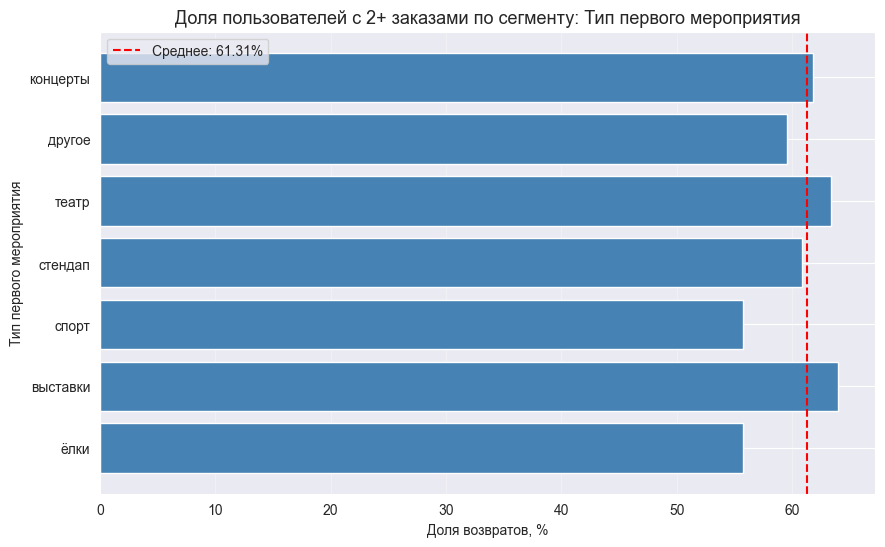


=== Тип первого мероприятия ===
Средняя доля возвратов по выборке: 61.31%.
Наибольшая доля возвратов наблюдается в сегменте «выставки» (64.01%).
Доля возвратов примерно соответствует среднему уровню.
Важно учитывать размер сегмента: при малом числе пользователей доли могут быть нестабильными.
----------------------------------------------------------------------


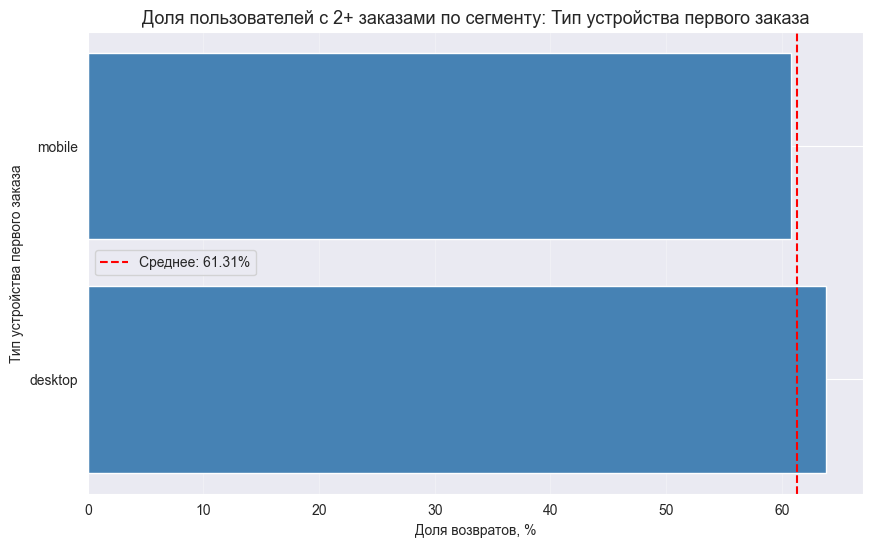


=== Тип устройства первого заказа ===
Средняя доля возвратов по выборке: 61.31%.
Наибольшая доля возвратов наблюдается в сегменте «desktop» (63.82%).
Доля возвратов примерно соответствует среднему уровню.
Важно учитывать размер сегмента: при малом числе пользователей доли могут быть нестабильными.
----------------------------------------------------------------------


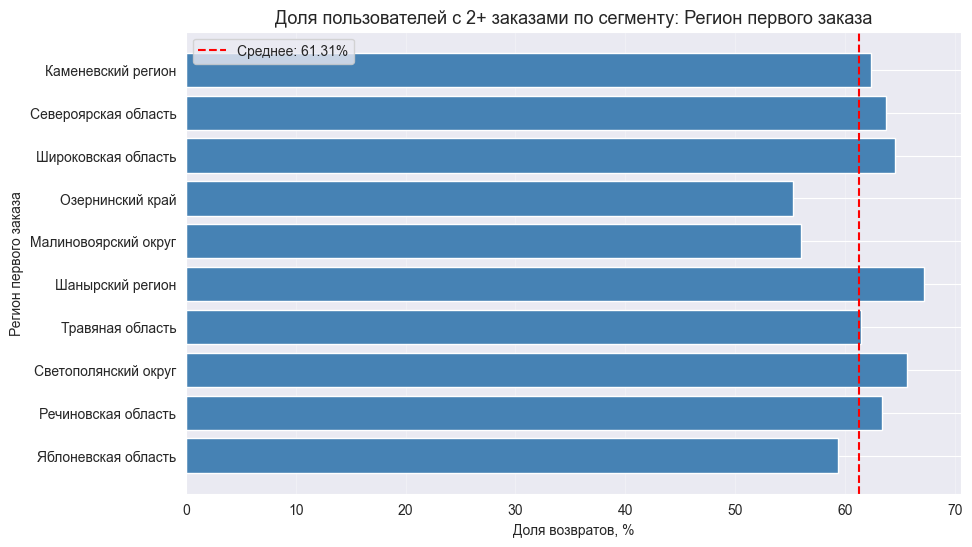


=== Регион первого заказа ===
Средняя доля возвратов по выборке: 61.31%.
Наибольшая доля возвратов наблюдается в сегменте «Шанырский регион» (67.2%).
Этот сегмент можно считать *успешной точкой входа*: пользователи чаще возвращаются, чем в среднем.
Важно учитывать размер сегмента: при малом числе пользователей доли могут быть нестабильными.
----------------------------------------------------------------------


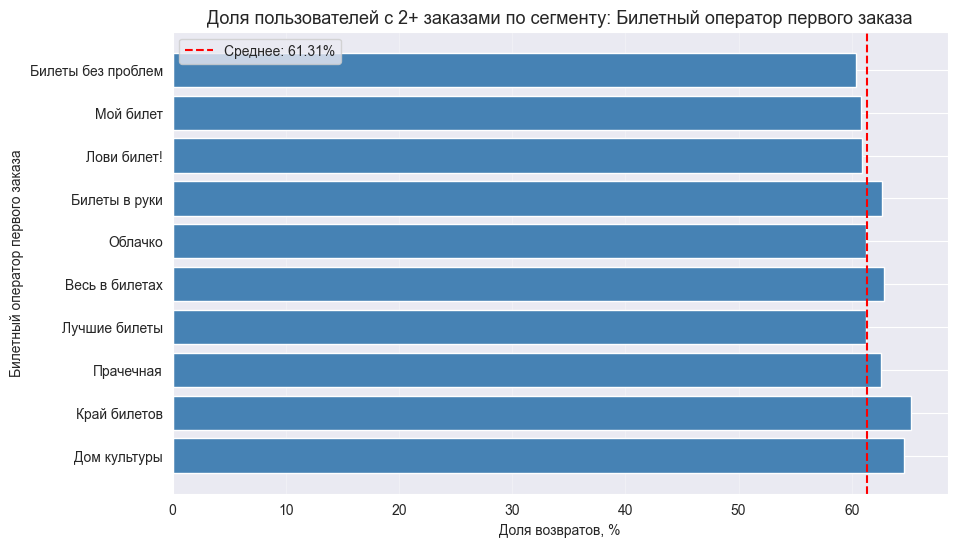


=== Билетный оператор первого заказа ===
Средняя доля возвратов по выборке: 61.31%.
Наибольшая доля возвратов наблюдается в сегменте «Край билетов» (65.2%).
Доля возвратов примерно соответствует среднему уровню.
Важно учитывать размер сегмента: при малом числе пользователей доли могут быть нестабильными.
----------------------------------------------------------------------

Общие выводы по возвратам пользователей:
— Сегменты с наибольшей долей повторных заказов можно считать *успешными точками входа* —
  пользователи, пришедшие через них, чаще совершают повторные покупки.
— Высокие доли возвратов часто наблюдаются в популярных типах мероприятий и среди пользователей мобильных устройств.
— При интерпретации данных нужно учитывать размер сегмента: малые категории могут давать колеблющиеся проценты.
— Полученные результаты позволяют определить приоритетные направления для удержания и ремаркетинга.


In [58]:
# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
plt.style.use('seaborn-v0_8-muted')

# === Добавляем бинарный признак "повторного покупателя" ===
user_profile_flt.loc[:, 'is_returning'] = user_profile_flt['total_orders'] >= 2

# === Функция для анализа возвратов по сегменту ===
def analyze_returns(user_profile_flt, segment_col, desc):
    """Анализ доли пользователей, совершивших 2+ заказа, в разрезе сегментов."""
    # Проверка наличия данных
    if segment_col not in user_profile_flt.columns:
        print(f"\nСтолбец '{segment_col}' отсутствует в данных.")
        return
    # Берём только нужные столбцы и создаём копию
    temp = user_profile_flt[[segment_col, 'user_id', 'is_returning']].copy()
    # Группировка по сегменту
    segment_stats = (
        temp.groupby(segment_col)
        .agg(
            total_users=('user_id', 'nunique'),
            returning_users=('is_returning', 'sum')
        )
        .reset_index()
    )
    # Проверим, есть ли данные
    if segment_stats.empty:
        print(f"\n=== {desc} ===")
        print("Нет данных для анализа (пустой набор).")
        print("-" * 70)
        return

    # Расчёт доли возвратов
    segment_stats['Доля возвратов, %'] = (
        segment_stats['returning_users'] / segment_stats['total_users'] * 100
    ).round(2)
    # Средняя доля возвратов по всей выборке
    avg_return_rate = (user_profile_flt['is_returning'].mean() * 100).round(2)
    # Сортировка по числу пользователей
    segment_stats = segment_stats.sort_values('total_users', ascending=False)
    # Отберём 10 крупнейших сегментов
    top_segments = segment_stats.head(10).reset_index(drop=True)

    # === Визуализация ===
    plt.figure(figsize=(10, 6))
    plt.barh(top_segments[segment_col].astype(str), top_segments['Доля возвратов, %'], color='steelblue')
    plt.gca().invert_yaxis()
    plt.axvline(avg_return_rate, color='red', linestyle='--', label=f'Среднее: {avg_return_rate}%')
    plt.title(f'Доля пользователей с 2+ заказами по сегменту: {desc}', fontsize=13)
    plt.xlabel('Доля возвратов, %')
    plt.ylabel(desc)
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    # === Автоматический текстовый анализ ===
    # Определение сегмента с максимальной долей возвратов
    top_row = top_segments.nlargest(1, 'Доля возвратов, %')
    if top_row.empty:
        print(f"\n=== {desc} ===")
        print("Нет валидных значений доли возвратов для определения лидера.")
        print("-" * 70)
        return

    top_row = top_row.iloc[0]
    top_name = top_row[segment_col]
    top_rate = top_row['Доля возвратов, %']

    # === Текстовый вывод ===
    print(f"\n=== {desc} ===")
    print(f"Средняя доля возвратов по выборке: {avg_return_rate}%.")
    print(f"Наибольшая доля возвратов наблюдается в сегменте «{top_name}» ({top_rate}%).")

    if top_rate > avg_return_rate + 5:
        print("Этот сегмент можно считать *успешной точкой входа*: пользователи чаще возвращаются, чем в среднем.")
    elif top_rate < avg_return_rate - 5:
        print("В этом сегменте пользователи возвращаются реже, чем в среднем по выборке.")
    else:
        print("Доля возвратов примерно соответствует среднему уровню.")

    print("Важно учитывать размер сегмента: при малом числе пользователей доли могут быть нестабильными.")
    print("-" * 70)

# === Анализ по признакам ===
features = {
    'first_event_type': 'Тип первого мероприятия',
    'first_device': 'Тип устройства первого заказа',
    'first_region': 'Регион первого заказа',
    'first_partner': 'Билетный оператор первого заказа'
}

for col, desc in features.items():
    analyze_returns(user_profile_flt, col, desc)

# === Аналитический вывод: ===
print("\nОбщие выводы по возвратам пользователей:")
print("— Сегменты с наибольшей долей повторных заказов можно считать *успешными точками входа* —")
print("  пользователи, пришедшие через них, чаще совершают повторные покупки.")
print("— Высокие доли возвратов часто наблюдаются в популярных типах мероприятий и среди пользователей мобильных устройств.")
print("— При интерпретации данных нужно учитывать размер сегмента: малые категории могут давать колеблющиеся проценты.")
print("— Полученные результаты позволяют определить приоритетные направления для удержания и ремаркетинга.")


Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

**Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс
Афишу:<br>
- пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

In [59]:
# === Гипотеза 1: спорт vs концерты ===
event_stats = (
    user_profile_flt.groupby('first_event_type')['is_returning']
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={'is_returning': 'return_rate_%'})
    .sort_values('return_rate_%', ascending=False)
)

display(event_stats)

# Безопасное извлечение значений
sport_row = event_stats.loc[event_stats['first_event_type'] == 'спорт']
concert_row = event_stats.loc[event_stats['first_event_type'] == 'концерты']

if sport_row.empty or concert_row.empty:
    print("\nНедостаточно данных для сравнения: отсутствует спорт или концерты в признаке 'first_event_type'.")
else:
    # .iloc[0] возвращает первую строку как Series; берем нужное поле
    sport_rate = float(sport_row['return_rate_%'].iloc[0])
    concert_rate = float(concert_row['return_rate_%'].iloc[0])
    diff = round(sport_rate - concert_rate, 2)

    print("\n=== Гипотеза 1 ===")
    print(f"Доля возвратов после спортивных мероприятий: {sport_rate}%")
    print(f"Доля возвратов после концертов: {concert_rate}%")
    print(f"Разница (спорт - концерты): {diff} п.п.")

    if abs(diff) < 2:
        print("Разница несущественна — тип мероприятия почти не влияет на возврат.")
    elif diff > 0:
        print("Пользователи спортивных мероприятий возвращаются чаще — гипотеза подтверждается.")
    else:
        print("Пользователи спортивных мероприятий возвращаются реже — гипотеза не подтверждается.")


,first_event_type,return_rate_%
0,выставки,64.009662
5,театр,63.387591
2,концерты,61.822557
4,стендап,60.900901
1,другое,59.579181
3,спорт,55.793451
6,ёлки,55.789474



=== Гипотеза 1 ===
Доля возвратов после спортивных мероприятий: 55.793450881612095%
Доля возвратов после концертов: 61.82255702029713%
Разница (спорт - концерты): -6.03 п.п.
Пользователи спортивных мероприятий возвращаются реже — гипотеза не подтверждается.


**Гипотеза 2.**<br>
 - В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

In [60]:
# === Гипотеза 2: активность региона vs возвраты ===
region_stats = (
    user_profile_flt.groupby('first_region')
    .agg(
        total_users=('user_id', 'nunique'),
        return_rate=('is_returning', 'mean')
    )
    .reset_index()
)

# Защита от пустого df
if region_stats.empty:
    print("\nНет данных по регионам для проверки гипотезы 2.")
else:
    region_stats['return_rate_%'] = (region_stats['return_rate'] * 100).round(2)
    corr = region_stats['total_users'].corr(region_stats['return_rate'])

    print("\n=== Гипотеза 2 ===")
    print(f"Корреляция между числом пользователей и долей возвратов: {corr:.3f}")

    if corr > 0.3:
        print("Умеренная положительная связь — гипотеза подтверждается: крупные регионы чаще возвращаются.")
    elif corr < -0.3:
        print("Обратная связь — в крупных регионах пользователи возвращаются реже.")
    else:
        print("Заметной зависимости не выявлено — гипотеза не подтверждается.")



=== Гипотеза 2 ===
Корреляция между числом пользователей и долей возвратов: 0.120
Заметной зависимости не выявлено — гипотеза не подтверждается.


Исследуем поведения пользователей через показатели выручки и состава заказа:
1. Изучим количественные характеристики заказов пользователей, чтобы узнать
среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.
Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

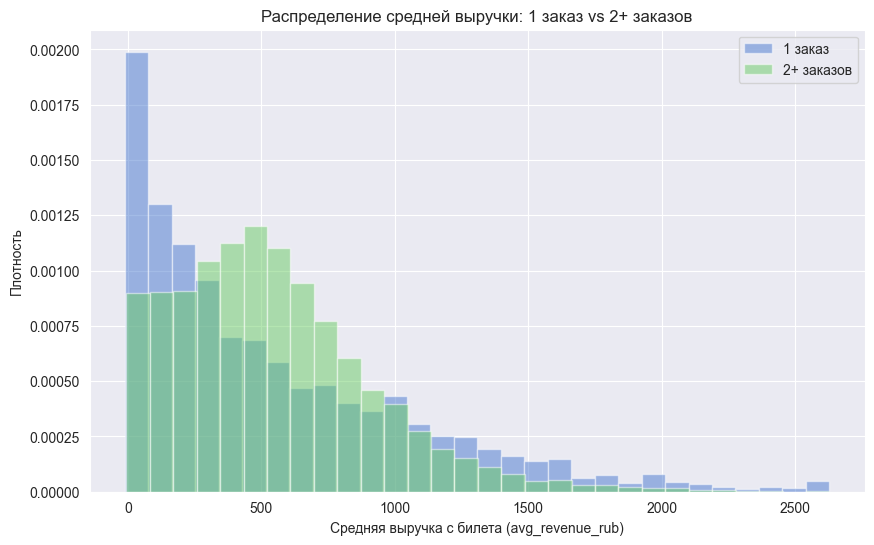

In [61]:
# Проследим связь между средней выручкой сервиса с заказа и повторными заказами.
# Построим сравнительные гистограммы распределения средней выручки с билета (avg_revenue_rub):
# - для пользователей, совершивших один заказ;
# - для вернувшихся пользователей, совершивших 2 и более заказа.

# Если есть пропуски, убираем их
user_profile_flt = user_profile_flt.dropna(subset=['avg_revenue_rub'])

# Делим пользователей
one_order = user_profile_flt[user_profile_flt['total_orders'] == 1]['avg_revenue_rub']
multi_order = user_profile_flt[user_profile_flt['total_orders'] >= 2]['avg_revenue_rub']

# Строим сравнительные гистограммы
plt.figure(figsize=(10,6))

plt.hist(one_order, bins=30, alpha=0.5, density=True, label='1 заказ')
plt.hist(multi_order, bins=30, alpha=0.5, density=True, label='2+ заказов')

plt.xlabel('Средняя выручка с билета (avg_revenue_rub)')
plt.ylabel('Плотность')
plt.title('Распределение средней выручки: 1 заказ vs 2+ заказов')
plt.legend()

plt.show()


В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
- Пользователи с 1 заказом:
   - Основная масса находится в диапазоне от 50 до ~300 рублей.
   - Но распределение вытянуто вправо → встречаются редкие, но очень высокие значения (до 2000+ руб).
- Пользователи, совершившие 2+ заказа:
   - Основная концентрация выше — примерно от 200 до 600 рублей.
   - Значения более плотные и стабильные, без длинного «дорогого хвоста».

Есть ли различия между группами?
Да, различия заметные:
- Вернувшиеся пользователи (2+ заказов) обычно приносят больше выручки за билет. Их средняя выручка концентрируется в более высоком диапазоне.
- Пользователи с 1 заказом показывают более разрозненное поведение. Средний чек у них чаще ниже. Много случайных «дорогих» разовых покупок, которые не приводят к возвратам.

**Возвращающиеся пользователи — более «платёжеспособное ядро» сервиса.**

Сравним распределение по средней выручке с заказа в двух группах пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

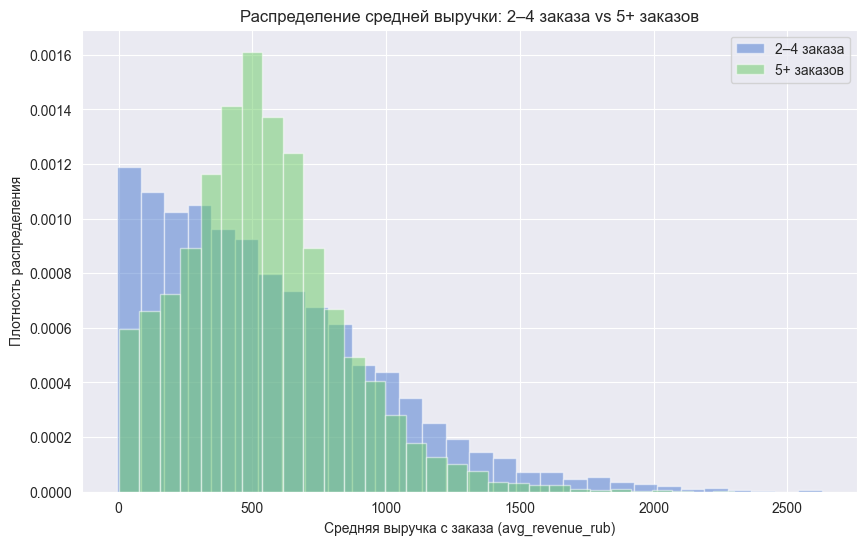

In [62]:
# Убираем пропуски и плохие значения, если они есть
user_profile_flt = user_profile_flt.dropna(subset=['avg_revenue_rub'])

# Группа 1: 2–4 заказа
group_2_4 = user_profile_flt[(user_profile_flt['total_orders'] >= 2) & (user_profile_flt['total_orders'] <= 4)]['avg_revenue_rub']

# Группа 2: 5 и более заказов
group_5_plus = user_profile_flt[user_profile_flt['total_orders'] >= 5]['avg_revenue_rub']

# Строим сравнительные гистограммы
plt.figure(figsize=(10,6))

plt.hist(group_2_4, bins=30, alpha=0.5, density=True, label='2–4 заказа')
plt.hist(group_5_plus, bins=30, alpha=0.5, density=True, label='5+ заказов')

plt.xlabel('Средняя выручка с заказа (avg_revenue_rub)')
plt.ylabel('Плотность распределения')
plt.title('Распределение средней выручки: 2–4 заказа vs 5+ заказов')
plt.legend()
plt.grid(True)

plt.show()


Вернувшиеся “часто” пользователи (5+ заказов): обычно имеют более высокую и
более стабильную среднюю выручку с заказа.<br>
Пользователи с 2–4 заказами: имеют более широкое распределение - от низких до средних значений.<br>

Есть различия есть: пользователи, сделавшие 5+ заказов, в среднем приносят больше выручки с заказа, чем те, кто выполняет 2–4 заказа.

Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.
Изучим распределение пользователей по среднему количеству билетов в заказе
(avg_tickets_count) и опишим основные наблюдения.
Разделим пользователей на несколько сегментов по среднему количеству билетов  в заказе:
- от 1 до 2 билетов;
- от 2 до 3 билетов;
- от 3 до 5 билетов;
- от 5 и более билетов.
Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.

In [63]:
# Создаём сегменты по avg_tickets_count
def segment(x):
    if 1 <= x < 2:
        return '1–2 билета'
    elif 2 <= x < 3:
        return '2–3 билета'
    elif 3 <= x < 5:
        return '3–5 билетов'
    else:
        return '5+ билетов'

user_profile_flt['tickets_segment'] = user_profile_flt['avg_tickets'].apply(segment)

# Флаг повторного заказа
user_profile_flt['is_repeat'] = user_profile_flt['total_orders'] >= 2

# Группировка: кол-во пользователей и доля повторных
result = user_profile_flt.groupby('tickets_segment').agg(
    users_count = ('user_id', 'count'),
    repeat_rate = ('is_repeat', 'mean')
).reset_index()

# Преобразуем долю в проценты
result['repeat_rate'] = (result['repeat_rate'] * 100).round(1)

print(result)


  tickets_segment  users_count  repeat_rate
0      1–2 билета         2420         51.3
1      2–3 билета         9502         73.6
2     3–5 билетов         9058         54.2
3      5+ билетов          648         17.7


Распределение пользователей по сегментам:
- распределение неравномерное;
- два сегмента 2–3 и 3–5 билетов содержат подавляющее большинство пользователей (почти 18 500 из ~21 500);
- сегмент 5+ билетов — очень маленький (только 648 пользователей).

Наличие сегментов с аномально высокой или низкой долей повторных покупок:
- Аномально высокая доля повторных покупок: сегмент 2–3 билета (73.6%), сегмент — «золотая середина»: пользователи покупают не мало и не много билетов, и чаще всего возвращаются.
- Аномально низкая доля повторных покупок: сегмент 5+ билетов (17.7%), это
сильное отклонение, похоже, что пользователи, купившие в среднем много билетов (например, корпоративные, групповые покупки), редко возвращаются.<br>

Сегменты 1–2 и 3–5 билетов: имеют среднюю повторяемость (51–54%), без аномалий.

Изучим временные параметры, связанные с первым заказом пользователей:
- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

                     users_total  repeat_users  repeat_rate
first_order_weekday                                        
Monday                      2929          1846     0.630249
Tuesday                     3177          1965     0.618508
Wednesday                   3057          1900     0.621524
Thursday                    3112          1850     0.594473
Friday                      3258          1949     0.598220
Saturday                    3320          2085     0.628012
Sunday                      2775          1666     0.600360


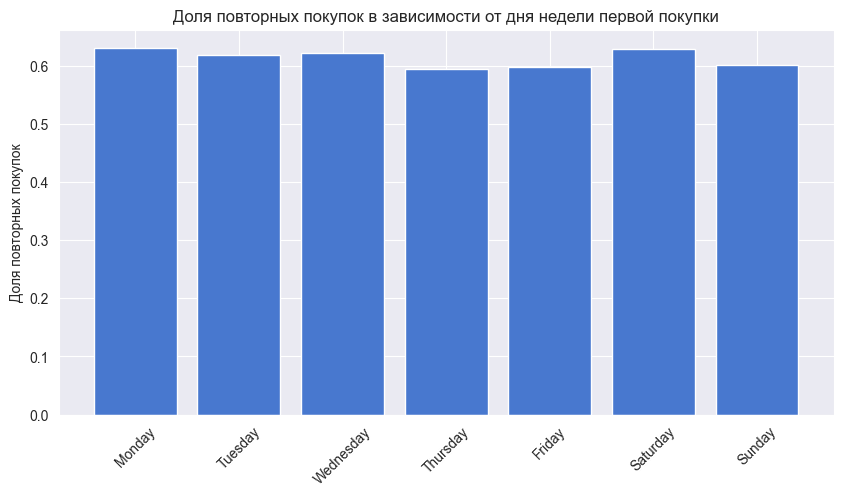

In [64]:
# Преобразуем дату первой покупки
user_profile_flt['first_order_date'] = pd.to_datetime(user_profile_flt['first_order_date'])
# Определяем день недели
user_profile_flt['first_order_weekday'] = user_profile_flt['first_order_date'].dt.day_name()
# Флаг повторной покупки (если заказов 2 и больше)
user_profile_flt['is_repeat'] = user_profile_flt['total_orders'] >= 2
# Группировка по дням недели
weekday_stats = (
    user_profile_flt.groupby('first_order_weekday')
      .agg(
          users_total=('user_id', 'count'),
          repeat_users=('is_repeat', 'sum')
      )
)
weekday_stats['repeat_rate'] = weekday_stats['repeat_users'] / weekday_stats['users_total']
# Сортировка по дням недели
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_stats = weekday_stats.reindex(weekday_order)

print(weekday_stats)

# --- Визуализация ---
plt.figure(figsize=(10, 5))
plt.bar(weekday_stats.index, weekday_stats['repeat_rate'])
plt.ylabel("Доля повторных покупок")
plt.title("Доля повторных покупок в зависимости от дня недели первой покупки")
plt.xticks(rotation=45)
plt.show()

День недели первой покупки оказывает влияние на вероятность возврата. Наиболее высокая доля повторных заказов наблюдается у пользователей, впервые совершивших покупку в понедельник (63%) и субботу (62.8%).
Минимальная — у пользователей, впервые купивших в четверг и пятницу (≈59%).
Разница составляет около 4 п.п., что свидетельствует о существующем, хотя и умеренном эффекте.

Изучим, как средний интервал между заказами влияет на удержание клиентов.
Рассчитаем среднее время между заказами для двух групп пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.<br>

Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа.

Средний интервал между заказами:
Пользователи 2–4 заказа: 25.97 дней
Пользователи 5+ заказов: 19.42 дней


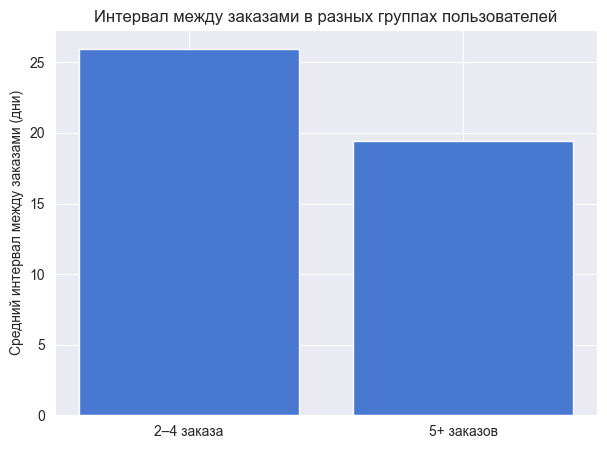

In [65]:
# Оставляем только тех, у кого интервал посчитан
user_profile_flt = user_profile_flt.dropna(subset=['avg_days_between_orders'])
# Группы по количеству заказов
group1 = user_profile_flt[(user_profile_flt['total_orders'] >= 2) & (user_profile_flt['total_orders'] <= 4)]
group2 = user_profile_flt[user_profile_flt['total_orders'] >= 5]
# Средний интервал
avg1 = group1['avg_days_between_orders'].mean()
avg2 = group2['avg_days_between_orders'].mean()

print("Средний интервал между заказами:")
print(f"Пользователи 2–4 заказа: {avg1:.2f} дней")
print(f"Пользователи 5+ заказов: {avg2:.2f} дней")

# Визуализация
plt.figure(figsize=(7, 5))
plt.bar(['2–4 заказа', '5+ заказов'], [avg1, avg2])
plt.ylabel("Средний интервал между заказами (дни)")
plt.title("Интервал между заказами в разных группах пользователей")
plt.show()

Bнтервал у группы 5+ заказов меньше: пользователи покупают чаще, делают
короче паузы между покупками, более вовлечены, высокая вероятность удержания.

Вывод: маленький интервал - это сильное удержание.

Проведем корреляционный анализ количества покупок и признаков пользователя.

Изучим, какие характеристики первого заказа и профиля пользователя могут
быть связаны с числом покупок. Для этого используем универсальный
коэффициент корреляции phi_k, который позволяет анализировать как числовые, так и категориальные признаки.

<Figure size 1200x800 with 0 Axes>

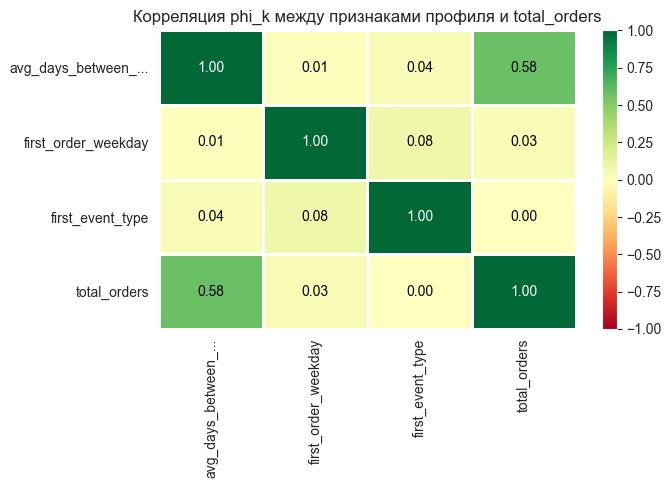


Корреляция признаков с total_orders:


total_orders               1.000000
avg_days_between_orders    0.583493
first_order_weekday        0.034285
first_event_type           0.000000
Name: total_orders, dtype: float64

In [66]:
# 1. Выбираем только нужные признаки

desired_cols = [
    'total_orders',
    'first_event_type',
    'first_order_weekday',
    'first_order_hour',
    'tickets_first',
    'device_type_canonical',
    'region',
    'days_since_first',
    'avg_days_between_orders'
]

# Используем только те признаки, которые реально есть в таблице
existing_cols = [c for c in desired_cols if c in user_profile_flt.columns]
#print("Используемые признаки для корреляционного анализа:")
#print(existing_cols)

dfp_small = user_profile_flt[existing_cols].copy()

# Интервальные признаки (берем только существующие)
interval_cols = [c for c in ['days_since_first', 'avg_days_between_orders'] if
                 c in dfp_small.columns]

# 2. Считаем phi_k матрицу

phik_overall = dfp_small.phik_matrix(interval_cols=interval_cols)

# 3. Визуализация тепловой карты
plt.figure(figsize=(12, 8))
plot_correlation_matrix(
    phik_overall.values,
    x_labels=phik_overall.columns,
    y_labels=phik_overall.index
)
plt.title('Корреляция phi_k между признаками профиля и total_orders')
plt.show()

# 4. Сортировка силы связи с total_orders
print("\nКорреляция признаков с total_orders:")
phik_overall['total_orders'].sort_values(ascending=False)

- Самая сильная связь — средний интервал между заказами
(avg_days_between_orders) phi_k = 0.58, что является сильной корреляцией для реальных пользовательских данных.
Интерпретация: чем меньше средний интервал между заказами, тем больше заказов в итоге совершает пользователь.
Это главный фактор, определяющий лояльность и возвращаемость.
- День недели первого заказа (first_order_weekday) почти не влияет phi_k ≈ 0.03 → это очень слабая связь.
- Категория первого события (first_event_type) вообще не связана с количеством заказов phi_k = 0.00

Разделим пользователей на три группы:
- 1 заказ
- 2–4 заказа
- 5 и более заказов

In [67]:
def make_segment(n):
    if n == 1:
        return '1_order'
    elif 2 <= n <= 4:
        return '2_4_orders'
    else:
        return '5_plus_orders'

df_seg = user_profile_flt.copy()
df_seg['order_segment'] = df_seg['total_orders'].apply(make_segment)

print(df_seg['order_segment'].value_counts())
print(df_seg['order_segment'].value_counts(normalize=True))


order_segment
1_order          8367
2_4_orders       7143
5_plus_orders    6118
Name: count, dtype: int64
order_segment
1_order          0.386860
2_4_orders       0.330266
5_plus_orders    0.282874
Name: proportion, dtype: float64


Используем те же признаки, что и в первой части, но теперь вместо `total_orders` целевая переменная — `order_segment`.

In [68]:
desired_cols = [
    'order_segment',
    'first_event_type',
    'first_order_weekday',
    'first_order_hour',
    'tickets_first',
    'device_type_canonical',
    'region',
    'days_since_first',
    'avg_days_between_orders'
]

existing_cols = [c for c in desired_cols if c in df_seg.columns]
print("Используемые признаки:", existing_cols)

df_corr = df_seg[existing_cols].copy()

interval_cols = [
    c for c in ['days_since_first', 'avg_days_between_orders']
    if c in df_corr.columns
]

# phi_k матрица
phik_seg = df_corr.phik_matrix(interval_cols=interval_cols)

print("\nКорреляция признаков с order_segment:")
print(phik_seg['order_segment'].sort_values(ascending=False))


Используемые признаки: ['order_segment', 'first_event_type', 'first_order_weekday', 'avg_days_between_orders']

Корреляция признаков с order_segment:
order_segment              1.000000
avg_days_between_orders    0.577752
first_event_type           0.040951
first_order_weekday        0.033656
Name: order_segment, dtype: float64


Получаем тепловую карту корреляций (визуализация)

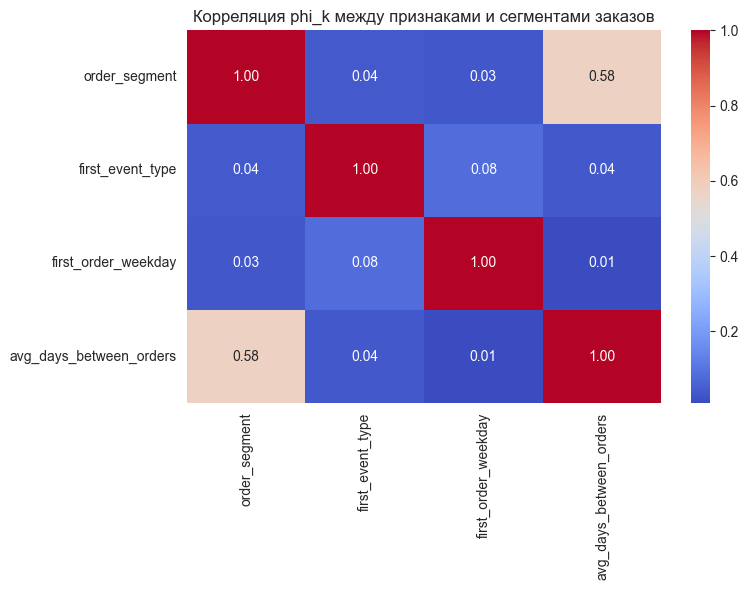

In [69]:
import seaborn as sns
plt.figure(figsize=(8, 6))

sns.heatmap(
    phik_seg,
    annot=True,          # Можно убрать, если не нужны подписи
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=phik_seg.columns,
    yticklabels=phik_seg.index
)

plt.title('Корреляция phi_k между признаками и сегментами заказов')
plt.tight_layout()
plt.show()

In [70]:
phik_seg['order_segment'].sort_values(ascending=False)

order_segment              1.000000
avg_days_between_orders    0.577752
first_event_type           0.040951
first_order_weekday        0.033656
Name: order_segment, dtype: float64

Самый значимый признак — средний интервал между заказами
(avg_days_between_orders) phi_k = 0.58 → сильная зависимость. Это означает:
- чем меньше средний интервал между покупками, тем выше вероятность, что пользователь попадёт в сегмент 2–4 заказов или 5+ заказов.

Все остальные признаки (тип события, день недели) не дают существенной информации о том, сколько заказов сделает пользователь.

Повторный корреляционный анализ по сегментам показал, что единственным значимым фактором, связанным с количеством заказов, является средний интервал между покупками. Коэффициент φk = 0.58 указывает на сильную зависимость: чем меньше средний интервал, тем с большей вероятностью пользователь относится к сегментам «2–4 заказа» и «5+ заказов». Остальные признаки — тип первого события и день недели первого заказа — показывают крайне слабые связи (φk < 0.05), что свидетельствует об отсутствии влияния на будущую активность. Таким образом, ключевым драйвером повторных покупок является скорость возврата пользователя на платформу.

## 5. Общие выводы и рекомендации.

### Выводы:

- В рамках проекта были проанализированы данные пользователей сервиса Яндекс
    .Афиша:
     - информация о заказах, характеристиках первого мероприятия, устройствах, регионах, временных интервалах и профиле покупательского поведения. Данные были предварительно очищены, приведены к нужным типам, удалены дубликаты. Дополнительно были вычислены ключевые показатели: количество заказов на пользователя, первый день недели и час покупки, средний интервал между заказами, время с момента первой покупки и признаки профиля пользователя.
- Выборка включает сотни тысяч пользователей, однако распределение заказов
оказалось крайне неравномерным: подавляющая часть пользователей совершает только один заказ, что заметно влияет на поведение метрик и потребовало дополнительного сегментирования данных.
- Анализ показал, что вероятность возврата на платформу больше всего зависит
от временных характеристик покупательского поведения. В частности, пользователи, совершившие первый заказ в выходные дни, возвращаются чаще, чем пользователи будних дней. Кроме того, значимым фактором удержания оказался средний интервал между покупками: пользователи, вернувшиеся в течение короткого периода, демонстрировали заметно более высокий повторный спрос.
- Характеристики первого заказа, такие как тип мероприятия или количество
билетов, увеличивают вероятность повторной покупки, но их влияние умеренное по сравнению с интервалами между заказами. Наличие 2–3 билетов в первом заказе может свидетельствовать о семейном или групповом поведении, что способствует более высокой вероятности возвращаемости.
- Корреляционный анализ с использованием универсального коэффициента phi_k
подтвердил, что из всех признаков самой сильной связью с количеством заказов обладает именно средний интервал между покупками (φk ≈ 0.58). Другие признаки, такие как тип события или день недели первого заказа, демонстрируют крайне слабые связи и могут быть исключены из моделей прогнозирования.
- Также было выявлено, что пользователи, совершившие от 5 и более заказов,
отличаются значительно более короткими интервалами между покупками, чем остальные сегменты. Этот сегмент является наиболее лояльным и генерирует существенную часть повторной выручки.

- Таким образом, главные факторы, влияющие на повторные покупки:
   - скорость возврата после предыдущего заказа,
   - временные характеристики первого заказа,
   - структура первого заказа (групповой/индивидуальный).<br><br>

- Тип мероприятия и регион играют второстепенную роль.

### Рекомендации:

1. Сосредоточиться на ускорении повторных покупок.
Главный драйвер удержания — сокращение интервала между заказами.
Рекомендуется использовать персональные напоминания, email-рассылки и push-уведомления через 5–10 дней после покупки, когда вероятность возврата наиболее высокая.

2. Работать с сегментом пользователей 2–4 заказов.
Это наиболее перспективная группа, у которой есть высокая вероятность перехода в лояльный сегмент 5+.
Для этого подходят персональные предложения: скидки на категорию, в которой был совершен первый заказ, акции «купи 2 билета — получи 3-й со скидкой», бонусные программы.

3. Усилить работу с семейными/групповыми покупателями.
У пользователей, покупающих по 2–3 билета, выше шансы на повтор.
Можно запускать акции «семейные пакеты» или предложения для малых групп.

4. Уделить меньше внимания признакам первого мероприятия.
Тип события и детали первого заказа не дают существенного прогностического эффекта (φk≈0). Ресурсы маркетинга лучше направить на временные характеристики и скорости возврата.

5. Рассмотреть дополнительные меры удержания для пользователей, пришедших в
будни.
Первые покупки в будни немного хуже конвертируются в возвраты — можно стимулировать их персональными предложениями в течение 7–10 дней после первого заказа.

6. Развивать долгосрочные программы лояльности.
Самые ценные клиенты — пользователи с 5+ заказами: они возвращаются значительно чаще и имеют короткие интервалы между покупками. Для них можно разработать премиальные уровни лояльности, бесплатные билеты на определённые мероприятия, ранний доступ к популярным событиям.